In [1]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
import cmcrameri.cm as ccm
plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'

In [2]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [3]:
params = {'vars': ['prec','t2','snow'],
          'states' : ['CA', 'WY'],
          'res': ['45','9','3']}
res_domain = {'3': ['d03','d04'],
               '9' :['d02'],
               '45':['d01']}
domain_state = {'d01':['CA','WY'],
                'd02':['CA','WY'],
                'd03':['CA'],
                'd04':['WY'],}
boundaries = {'d01':{'CA': [43,60,35,68], ## left, right, bottom, top
                     'WY': [68,81,43,63]},
              'd02':{'CA': [44,125,87,251],
                     'WY': [165,230,130,227]},
              'd03':{'CA': [0,-1,0,-1]},
              'd04':{'WY': [0,-1,0,-1]}}
state_res_domain = {'CA': {'45':'d01',
                            '9': 'd02',
                            '3':'d03'},
                     'WY': {'45':'d01',
                            '9': 'd02',
                            '3':'d04'},}
                     
gcms_dict = {'d01': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
                     'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
                     'canesm5','access-cm2','ec-earth3'],
             'd03': ['ec-earth3-veg'],
             'd04': ['ec-earth3-veg'],}

bc = 'BC'

In [4]:
partition = np.load('/glade/campaign/uwyo/wyom0112/berkeley/partition_annual.npy',allow_pickle = True).flatten()[0]
alldata = np.load('/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped.npy',allow_pickle = True).flatten()[0]

In [5]:
partitions = []
#  = []
for gcm in gcms_dict['d02']:
    try:
        partition = np.load(f'/glade/campaign/uwyo/wyom0112/berkeley/partition_annual_{gcm}.npy',allow_pickle = True).flatten()[0]
        #alldata = np.load(f'/glade/campaign/uwyo/wyom0112/berkeley/annual_max_clipped_{gcm}.npy',allow_pickle = True).flatten()[0]
        partitions.append(partition)
        #alldatas.append(alldata)
    except:
        print(gcm)

ukesm1-0-ll


In [6]:
annual_pdd = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/annual_pdd_d02.nc')
annual_dd = xr.open_dataset('/glade/campaign/uwyo/wyom0112/berkeley/annual_dd_d02.nc')
mygcms = ['cesm2',
 'mpi-esm1-2-lr',
 'cnrm-esm2-1',
 'ec-earth3-veg',
 'fgoals-g3',
 'canesm5',
 'access-cm2',
 'ec-earth3']
years = range(1981,2099)
snowmasks = np.load('/glade/work/mcowherd/snowmasks.npy', allow_pickle = True).flatten()[0]


In [7]:
def prep_elbow(partition):
    ress = ['45','9']
    ws = 10
    var = 'prec'
    outs = []
    desc = []
    snows = []
    rains = []
    for i,state in enumerate(params['states']):
        for res in ress:
            for j,ptype in enumerate(['snowfall','rainfall']):
                domain = state_res_domain[state][res]
                mask = snowmasks[state][res]
                left, right, bottom, top = boundaries[domain][state]
                tmp = partition[state][res][ptype].sel(lat2d = slice(bottom, top),
                                                                           lon2d = slice(left, right))['prec']
                data = np.nanmean(tmp.where(mask), axis = (1,2))[1:-2]
                outs.append(data)
                desc.append(f'{state}_{res}_{ptype}')                
       
            domain = state_res_domain[state][res]
            mask = snowmasks[state][res]
            left, right, bottom, top = boundaries[domain][state]
            tmpsnow = partition[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                                       lon2d = slice(left, right))['prec']
            tmprain = partition[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))['prec']
            snowdata = np.nanmean(tmpsnow.where(mask), axis = (1,2))[1:-2]
            raindata = np.nanmean(tmprain.where(mask), axis = (1,2))[1:-2]
            snows.append(snowdata)
            rains.append(raindata)
    return outs,snows,rains,desc
        

/glade/derecho/scratch/mcowherd/tmp/ipykernel_15617/2698691888.py:122: RuntimeWarning: Mean of empty slice
  ax.plot(rolling_yearmean, np.nanmean(np.array(mydata), axis = 0), color = 'k', linestyle = resstyles[ires])


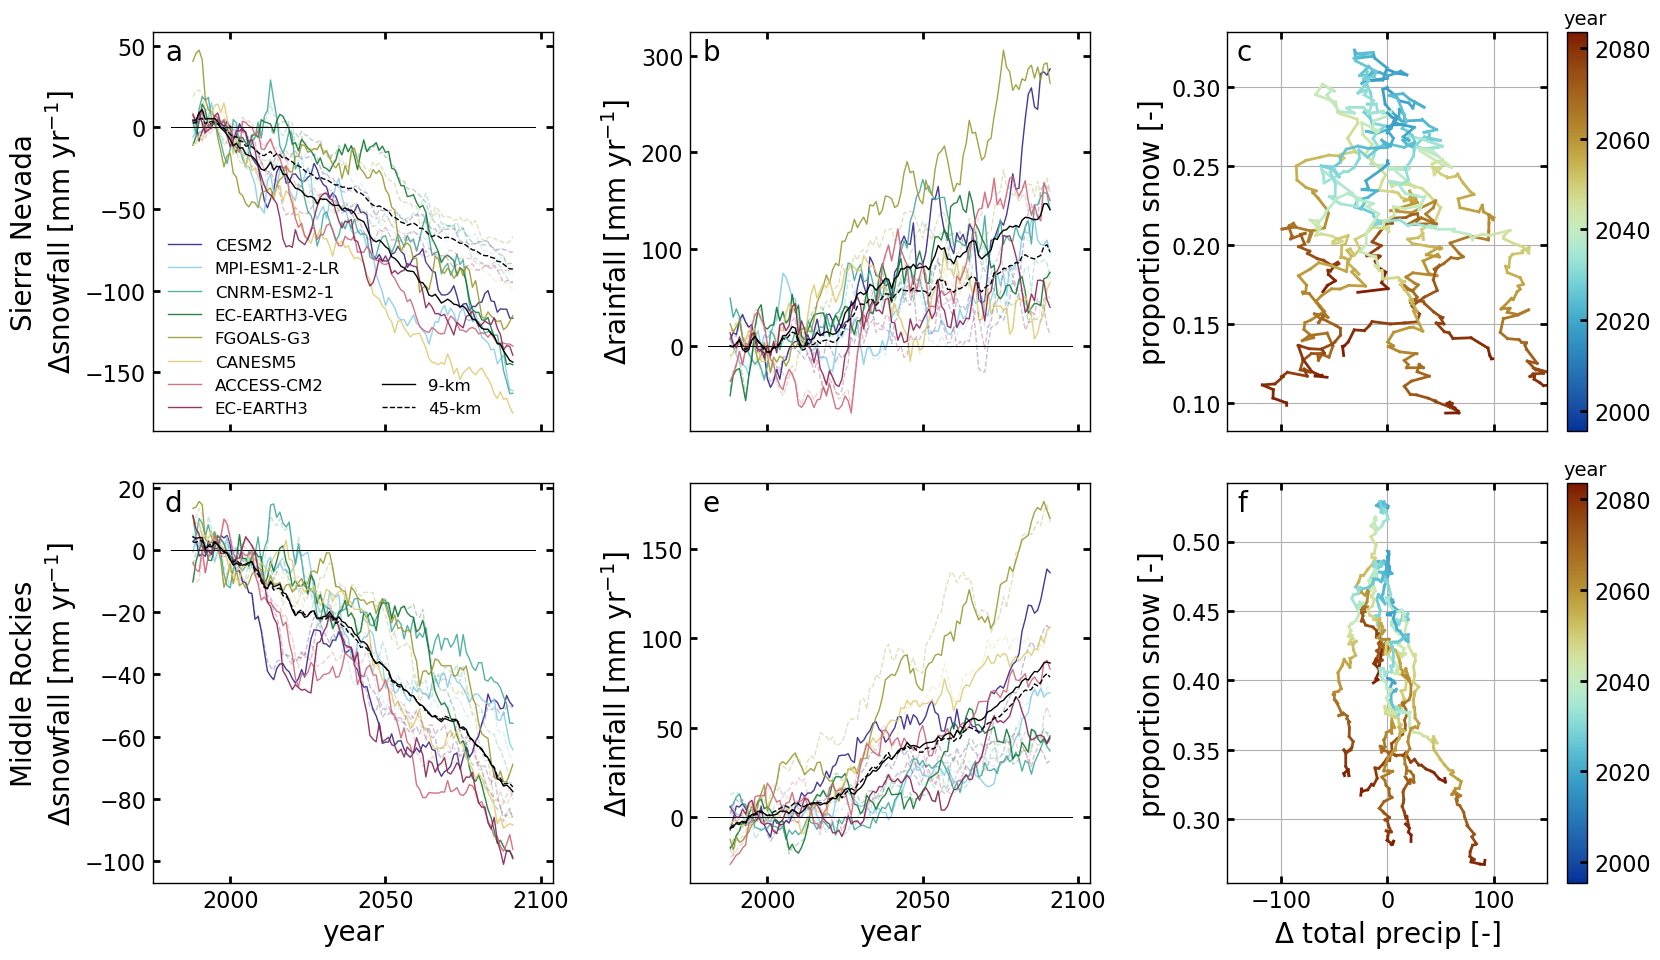

In [42]:
ws = 15
resstyles = ['--','-']
alphas = [0.3,0.9]
colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255","#AA4499"] #,"brown","fd3c06","gray"]]
fig,axs = plt.subplots(2,3, figsize = (17,10))
names = {'CA':'Sierra Nevada', 'WY':'Middle Rockies'}
x1s = []
y1s = []
x2s = []
y2s = []

lines = {}


for k,gcm in enumerate(mygcms):
    partition = partitions[k]
    ress = ['45','9']
    lines[gcm] = {}
    var = 'prec'
    for i,state in enumerate(params['states']):
        lines[gcm][state] = {}
        for l,res in enumerate(ress):
            lines[gcm][state][res] = {}
            for j,ptype in enumerate(['snowfall','rainfall']):
                ax = axs[i,j]
                #ax.grid(True)
                ax.plot([years[0],years[-1]], [0,0],'black', linewidth = 0.7)
                domain = state_res_domain[state][res]
                mask = snowmasks[state][res]
                left, right, bottom, top = boundaries[domain][state]
                tmp = partition[state][res][ptype].sel(lat2d = slice(bottom, top),
                                                                           lon2d = slice(left, right))['prec']
                data = np.nanmean(tmp.where(mask), axis = (1,2))[1:-2]
                years = range(1981,2099)
                # ax.plot(years, data, linestyle = ':', alpha = 0.4)
                rolling_yearmean = pd.DataFrame(years).rolling(window = ws).mean()
                rolling_mean = pd.DataFrame(data).rolling(window=ws).mean()
                ax.plot(rolling_yearmean,rolling_mean - np.nanmean(rolling_mean[ws:2*ws]), linestyle = resstyles[l], color = colors[k], alpha = alphas[l], label = gcm.upper())
                lines[gcm][state][res][ptype] = rolling_mean - np.nanmean(rolling_mean[ws:2*ws])
                # ax.hlines(np.nanmean(data[0:20]), 1980, 2100, linewidth = 1)
                ax.set_ylabel(r'$\Delta$' + f'{ptype}'+r' [mm yr$^{-1}$]')
                name = names[state]
                if i == 0: 
                    ax.set_xticklabels([])
                if j == 0: ax.set_ylabel(f'{name}\n'+r'$\Delta $'+f'{ptype}'+r' [mm yr$^{-1}$]')
                if i == 1: ax.set_xlabel('year')

        
        j = 2
        res = '9'
        ax = axs[i,j]
        domain = state_res_domain[state][res]
        mask = snowmasks[state][res]
        left, right, bottom, top = boundaries[domain][state]
        tmpsnow = partition[state][res]['snowfall'].sel(lat2d = slice(bottom, top),
                                                                   lon2d = slice(left, right))['prec']
        tmprain = partition[state][res]['rainfall'].sel(lat2d = slice(bottom, top),
                                                               lon2d = slice(left, right))['prec']
        snowdata = np.nanmean(tmpsnow.where(mask), axis = (1,2))[1:-2]
        raindata = np.nanmean(tmprain.where(mask), axis = (1,2))[1:-2]
        precip = snowdata + raindata
        ws2 = 30
        dprecip = (precip / np.nanmean(precip)) #  - np.nanmean(precip[0:30]))  /  np.nanmean(precip[0:30])
        rollyears = pd.DataFrame(years).rolling(window = ws2).mean()[0].values
        rollsnow = pd.DataFrame(snowdata).rolling(window = ws2).mean()[0].values
        rollrain = pd.DataFrame(raindata).rolling(window = ws2).mean()[0].values
        rolldprecip = pd.DataFrame(dprecip).rolling(window = ws2).mean()[0].values
        rollprecip = pd.DataFrame(precip).rolling(window = ws2).mean()[0].values
        cmap = ccm.roma_r
        x = rollprecip  - np.nanmean(rollprecip[0:30])
        y = rollsnow/rollprecip
        c = np.linspace(0,1,len(rollyears))
        for i in range(len(x) - 1):
            ax.plot(x[i:i+2], y[i:i+2], color=cmap(c[i]), linewidth=2)

        
        if k == 0:
            ax.set_ylabel('proportion snow [-]')
            norm = mcolors.Normalize(vmin=np.nanmin(rollyears), vmax=np.nanmax(rollyears))
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            plt.colorbar(sm, ax =ax)
    
            ax.grid(True)
            ax.set_xlim((-150,150))
            ax.text(1.05,1.02,'year',rotation=0, transform=ax.transAxes, fontsize = 14)        

        
## legend additions
axs[0,0].plot([2000,2000],[0,1], 'k-',label = '9-km', zorder = 0)
axs[0,0].plot([2000,2000],[0,1], 'k--',label = '45-km', zorder = 0)
axs[0,0].plot([2000,2000],[0,1], 'k--',label = '45-km', zorder = 0, alpha = 0)

h, l = axs[0,0].get_legend_handles_labels()
pos = [1,3,5,7,9,11,13,15]
h1 = [h[i] for i in pos]
l1 = [l[i] for i in pos]
for i in range(6): ## add invisible handles and empty labels to make the columns work
    h1.append(h[-1])
    l1.append('')
for i in [16,17]:
    h1.append(h[i])
    l1.append(l[i])
leg = axs[0,0].legend(h1,l1, ncol = 2, fontsize = 12)
axs[0,2].set_xticklabels([])
ax.set_xlabel (r'$\Delta$ total precip [-]')
plt.tight_layout()

for i,ax in enumerate(axs.flatten()): 
    ax.text(0.03, 0.93, chr(i + 97), transform = ax.transAxes)


states = params['states']
ptypes = ['snowfall','rainfall']
for istate, state in enumerate(states):
    for ires,res in enumerate(ress):
        for iptype, ptype in enumerate(ptypes):
            mydata = []
            for gcm in mygcms:
                data = lines[gcm][state][res][ptype]
                mydata.append(data.values.flatten())
            ax = axs[istate,iptype]
            ax.plot(rolling_yearmean, np.nanmean(np.array(mydata), axis = 0), color = 'k', linestyle = resstyles[ires])



plt.savefig('../figures/fig_psnow.jpg', dpi = 400)
plt.show()

In [36]:
np.array(mydata).shape

(8, 118)

In [10]:
states =params['states']
ptypes = ['snowfall','rainfall']
arrs = []
i = 0
for state in states:
    for res in ress:
        for ptype in ptypes:
            list = []
            for gcm in mygcms:
                data = lines[gcm][state][res][ptype]
                list.append(data)
            arr = np.array(list)
            arrs.append(arr)
            print(i, state, res, ptype)
            print(f'mean: {np.nanmean(arr[:,-5], axis = (0))[0]} mm')
            print(f'stdev: {np.nanstd(arr[:,-5], axis = (0))[0]} mm')
            i+=1

0 CA 45 snowfall
mean: -82.28692871848742 mm
stdev: 7.822174614544134 mm
1 CA 45 rainfall
mean: 92.00636914571125 mm
stdev: 49.91567748963207 mm
2 CA 9 snowfall
mean: -132.65835286935172 mm
stdev: 14.405014802573335 mm
3 CA 9 rainfall
mean: 130.80981818305122 mm
stdev: 89.37566999412675 mm
4 WY 45 snowfall
mean: -73.40966571172078 mm
stdev: 12.03916524904089 mm
5 WY 45 rainfall
mean: 73.4332398308648 mm
stdev: 40.74819039571615 mm
6 WY 9 snowfall
mean: -74.09085523393418 mm
stdev: 20.222924769798748 mm
7 WY 9 rainfall
mean: 81.25898224724662 mm
stdev: 43.072028624358445 mm


SN snowfall (a) decreases by 132 $\pm$ 14 mm in the 9-km resolution but only 82 $\pm$ 8 mm in the 45-km resolution by 2100. % is this because orographic? 
MR snowfall (d) decreases by 74 $\pm$ 20 mm  in the 9-km resolution and 73 $\pm$ 12 mm in the 45-km resolution.

SN rainfall (b) increases by 130 $\pm$ 89 mm in the 9-km resolution and only 92 $\pm$ 50 mm in the 45-km resolution by 2100. 
MR rainfall (e) increases by 81 $\pm$ 43 in the 9-km resolution and 73 $\pm$ 40 in the 45-km resolution.